In [2]:
import numpy as np
import pandas as pd
import MySQLdb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.integrate import odeint

# Define all models 

def engelandmay(pre_transport, boulder_density, Vabc, abc):
    q = 0.73 # boulder area coefficient. empirically determined average value (Aphoto/Aaxes)
    
    if pre_transport == "Joint Bounded":
        # Minimum wave height of a tsunami to dislodge a boulder in JBB scenario
        H_T_dislodge = ((boulder_density-water_density)*Vabc**np.cos(alpha)+miu*np.sin(alpha))/(2*water_density*c_l*abc[0]*abc[1]*q)

        # Minimum swell wave height to dislodge a boulder in JBB scenario
        H_S_dislodge = ((boulder_density-water_density)*Vabc**np.cos(alpha)+miu*np.sin(alpha))/(0.5*water_density*c_l*abc[0]*abc[1]*q)
        
    else:
        H_T_dislodge = None
        H_S_dislodge = None

    # Minimum wave height for storm waves to deposit boulder at location
    H_S_deposit = (2*miu*Vabc*boulder_density)/(c_d*abc[0]*abc[2]*q*water_density)
    
    # Minimum wave height for tsunami waves to deposit boulder at location
    H_T_deposit = (0.5*miu*Vabc*boulder_density)/(c_d*abc[0]*abc[2]*q*water_density)
    
    return(H_T_dislodge, H_S_dislodge, H_S_deposit, H_T_deposit)

def nandasena(pre_transport, boulder_density, abc):
    # Minimum flow velocity for incipient motion for submerged and subaerial boulders 
    # Assumed that in subaerial setting, the flow acceleration is insignificant, so inertia force can be ignored. 
    if pre_transport == "Submerged" or pre_transport == "Subaerial":
        
        sliding_condition = (2*(boulder_density/water_density-1)*g*abc[2]*(miu*np.cos(alpha)+np.sin(alpha)))/(c_d*(abc[2]/abc[1])+miu_s*c_l)
        overturn_rolling_condition = (2*(boulder_density/water_density-1)*g*abc[2]*(np.cos(alpha)+(abc[2]/abc[1])*np.sin(alpha)))/((c_d)*(abc[2]**2/abc[1]**2)+c_l)
        saltation_condition = (2*(boulder_density/water_density-1)*g*abc[2]*np.cos(alpha))/c_l
        
        u_square = min(sliding_condition, overturn_rolling_condition, saltation_condition)
        
        if u_square == sliding_condition:
            transport_mode = "Sliding"
        
        elif u_square == overturn_rolling_condition:
            transport_mode = "Overturn or Rolling"
        
        elif u_square == saltation_condition:
            transport_mode = "Saltation"
        
        u = u_square**0.5
    
    # Minimum flow velocity for incipient motion for joint bounded boulders
    elif pre_transport == "Joint Bounded":
        u = ((2*(boulder_density/water_density-1)*g*abc[2]*(np.cos(alpha)+miu_s*np.sin(alpha)))/c_l)**0.5
        transport_mode = None
    
    else:
        u = None
        transport_mode = None
        
    return (u, transport_mode)

def pignatelli(boulder_density, abc):
    # Minimum tsunami wave height for incipient motion (H_T)                        
    H_T = abc[2]*(boulder_density/water_density-1)/(2*c_l)
 
    # Transport distance of boulder inland (D)
    k = 0.06                    # constant that eqals 0.06 for most tsunamis
    if H_T > h_c: 
        D = X_max-((H_T-h_c)**1.33)*(manning**(-2))*k*np.cos(alpha)
    else:
        D = 0
    
    return (H_T, D)

# Manning table
manning_dict = {"Lagoon, fluvial plain": (0.01, 0.015),
                "Mediterranean vegetation": (0.016, 0.025),
                "Farm area": (0.026, 0.035),
                "Discontinuous dune belts (without vegetation)": (0.036, 0.040),
                "Dune belts (AltitudeN3 m)": (0.041, 0.046),
                "Rocky coasts (very karsificated)": (0.047, 0.052),
                "Urban area discontinuous": (0.053, 0.058),
                "Urban area (with buildings very concentrated)": (0.059, 0.064),
                "Mangroves": (0.065, 0.069),
                "Forests, Pinewood, etc.": (0.07, 0.07)
                }

def goto_apply(boulder_density, Vabc, abc, delta):
    # Let y be the speed of the boulder
    # Implement assuming that wave height is approximately a constant value
    def goto_model(y,t,H,v_miu):
        Fb = v_miu*(boulder_density-water_density)*Vabc*g*np.cos(y/abs(y))
        Fg = (boulder_density-water_density)*Vabc*g*np.sin(alpha)
        dydt=(0.5*c_d*water_density*abc[0]*abc[2]*(np.sqrt(delta*g*H)-y)*abs(np.sqrt(delta*g*H)-y)-Fb-Fg)/(boulder_density*Vabc+(c_m-1)*water_density*Vabc)
        return dydt

    # Initial Conditions
    y0=0.0000001

    # Time scale to solve ode
    t = np.linspace(0,1000, 200)

    # Solve ODE for y
    y = odeint(goto_model, y0, t, args=(H,v_miu))

    # Plot results
    #plt.plot(t,y)
    #plt.xlabel('Time')
    #plt.ylabel('Speed of the Boulder')
    #plt.show
    return y[95][0] # Return one of the speed values at a later time point

def rms(predicted, actual): # Generates the RMS value per model
    RMS = 0
    count = 0
    for l in range(len(predicted)):
        p = predicted[l]
        a = actual[l]
        if np.isnan(a)==False and p!=None: # only sum the RMS for boulders that have the relevant data
            sq_diff = (p-a)**2
            RMS = RMS + sq_diff
            count = count + 1
    if count > 0:        
        return((RMS/count)**0.5) 
    
    else:
        return(None)

In [3]:
def runmodels():
    emls_htdislodge = []
    emls_hsdislodge = []
    emls_hsdeposit = []
    emls_htdeposit = []
    gls_t = []
    gls_s = []
    nls = []
    pls_ht = []
    pls_d = []
    lt_actual = []


    for id, row in filt_df.iterrows():
        # Assign variable names to desired variables
        event = filt_df.loc[id, 4]
        boulder_ID = filt_df.loc[id, 5]
        pre_transport = filt_df.loc[id, 21]
        boulder_density = filt_df.loc[id, 14]
        Vabc = filt_df.loc[id, 9]
        abc = (filt_df.loc[id, 6], filt_df.loc[id, 7], filt_df.loc[id, 8])
        lateral_transport_distance = filt_df.loc[id, 22]
        
        
        # Run the Engel and May Model
        #resultem = engelandmay(pre_transport, boulder_density, Vabc, abc)
        #emls_htdislodge.append(resultem[0])
        #emls_hsdislodge.append(resultem[1])
        #emls_htdeposit.append(resultem[3])
        #emls_hsdeposit.append(resultem[2])
        
        #print("Engel and May", resultem) # H_T_dislodge, H_S_dislodge, H_S_deposit, H_T_deposit
        
        '''
        # Run the Goto Model
        resultgoto_tsunami = goto_apply(boulder_density, Vabc, abc, 4) # delta = 4 Wave typology for Tsunami from Fukui et. al 1973
        resultgoto_storm = goto_apply(boulder_density, Vabc, abc, 1) # delta = 1 Wave typology for Swell Wave from Fukui et. al 1973
        gls_t.append(resultgoto_tsunami)
        gls_s.append(resultgoto_storm)
        #print("Goto", resultgoto_tsunami, resultgoto_storm) # Boulder speed
        '''
        # Run the models that require a pre-transport setting
        if pre_transport != None: 

            # Run the Nandansena model
            #resultn = nandasena(pre_transport, boulder_density, abc)
            #nls.append(resultn)
            #print("Nandasena", resultn) # Minimum velocity

            # Run the Pignatelli model
            if pre_transport == "Joint Bounded":
                resultp = pignatelli(boulder_density, abc)
                pls_ht.append(resultp[0])
                pls_d.append(resultp[1])
                #print("Pignatelli", resultp)  #H_T, D
                
            else:
                pls_ht.append(None)
                pls_d.append(None)
                #print("Pignatelli", (None, None))
        
        else:
            pls_ht.append(None)
            pls_d.append(None)
            #nls.append(None)
        
        if lateral_transport_distance != None:
            lt_actual.append(lateral_transport_distance)
            
        else:
            lt_actual.append(None)

    return(emls_htdislodge, emls_hsdislodge, emls_hsdeposit, emls_htdeposit, gls_t, gls_s, nls, pls_ht, pls_d, lt_actual)

In [4]:
# Fetch data from boulder data set
db = MySQLdb.connect(host="localhost",  # your host
                     user="root",       # username
                     passwd="$u1840974f22603",     # password
                     db="boulders")   # name of the database

# Create a Cursor object to execute queries.
cur = db.cursor()


cur.execute('SELECT*FROM boulder_data4')     # Select data from table using SQL query.
boulder_sql = cur.fetchall()              # Fetch all the remaining rows. Displays as tuples.

boulder_df = pd.DataFrame(boulder_sql)

# Convert data to float.
boulder_df.iloc[:, 6:20] = boulder_df.iloc[:, 6:20].apply(pd.to_numeric)
boulder_df.iloc[:, 22:25] = boulder_df.iloc[:, 22:25].apply(pd.to_numeric)
boulder_df.iloc[:, 27] = boulder_df.iloc[:, 27].apply(pd.to_numeric)
boulder_df.iloc[:, 29] = boulder_df.iloc[:, 29].apply(pd.to_numeric)

#boulder_df.iloc[127,:] # Display data at row and column

In [5]:
# Filter the SQL database

#boulder_df1 = boulder_df.iloc[345:457, 1:41]

boulder_df1 = boulder_df.iloc[:, 1:41]

ls = []

for ind, row in boulder_df1.iterrows():
    # Assign variable names to desired variables
    event = boulder_df1.loc[ind, 4]
    pre_transport = boulder_df1.loc[ind, 21]
    boulder_density = boulder_df1.loc[ind, 14]
    Vabc = boulder_df1.loc[ind, 9]
    abc = (boulder_df1.loc[ind, 6], boulder_df1.loc[ind, 7], boulder_df1.loc[ind, 8])
    
    if np.isnan(boulder_density)==True or np.isnan(Vabc)==True or np.isnan(abc[0])==True or np.isnan(abc[1])==True or np.isnan(abc[2])==True:
        ls.append(ind)

filt_df = boulder_df1.drop(ls)

In [6]:
# Pick a set of parameters

# Parameters from Engel and May, Goto, Pignatelli, Nandasena
water_density = 1020
c_l = 0.178 # lift coefficient

# Paramter from Engel and May
miu = 0.65 # coefficient of static friction. estimated by Benner

# Pignatelli, Nandasena also requires alpha
manning = 0.03
alpha = 35
alpha = (alpha/360)*(2*np.pi) # Convert to radians
h_c = 0
X_max = 190                   

# Parameter for Nandasena
miu_s = 0.7

# Parameters from Goto
c_d = 1.05 # drag coefficient estimated from Goto
c_m = 1.67 # mass coefficient estimated from Goto # Nandasena also took 2.0
g = 9.81
H = 6 # Tsunami height
v_miu = 0.65 # variable miu 

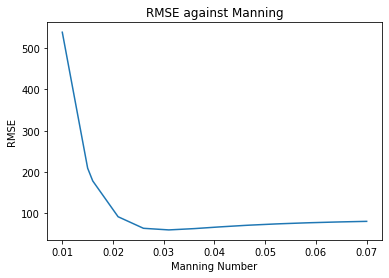

In [15]:
# Fit the Pignatelli model

# Vary the Manning Number
rms_ls = []
mann_ls = []
for i in manning_dict:     # iterate through manning table
    ran = np.arange(manning_dict[i][0], manning_dict[i][1]+0.0005, 0.005)  # generate range of possible manning values per coastal type
    for mann in ran: # filter output data into those with manning number of interest
        manning = mann
        results = runmodels() # emls, gls, nls, pls, lt_actual
        rms_value = rms(results[8], results[9])
        rms_ls.append(rms_value)
        mann_ls.append(manning)

plt.plot(mann_ls, rms_ls)
plt.title("RMSE against Manning")
plt.xlabel("Manning Number")
plt.ylabel("RMSE")
plt.savefig('rmsmanning.eps')
plt.show()

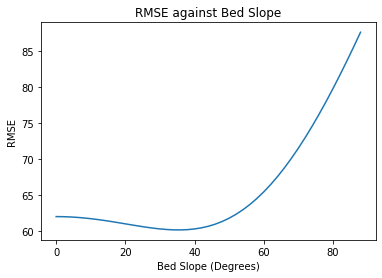

In [17]:
# Vary alpha
rmsalpha_ls = []
alpha_ls = []

for a in range(0, 90, 2):
    alpha = a 
    alpha = (alpha/360)*(2*np.pi)
    results = runmodels()
    rms_value = rms(results[8], results[9])
    rmsalpha_ls.append(rms_value)
    alpha_ls.append(a)

plt.plot(alpha_ls, rmsalpha_ls)
plt.title("RMSE against Bed Slope")
plt.xlabel("Bed Slope (Degrees)")
plt.ylabel("RMSE")
plt.savefig('rmsalpha.eps')
plt.show()

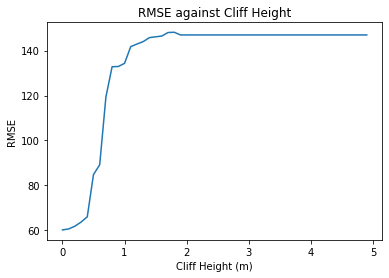

In [19]:
# Vary h_c
rmshc_ls = []
hc_ls = []

for h in np.arange(0, 5, 0.1):
    h_c =  h
    results = runmodels()
    rms_value = rms(results[8], results[9])
    rmshc_ls.append(rms_value)
    hc_ls.append(h_c)

plt.plot(hc_ls, rmshc_ls)
plt.title("RMSE against Cliff Height")
plt.xlabel("Cliff Height (m)")
plt.ylabel("RMSE")
plt.savefig('rmshc.eps')
plt.show()

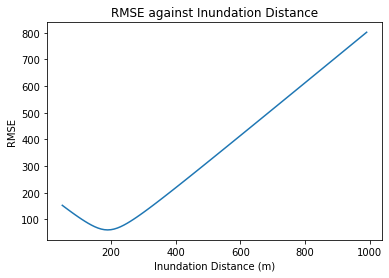

In [21]:
# Vary X_max
rmsx_ls = []
x_ls = []

for x in np.arange(50, 1000, 10):
    X_max = x
    results = runmodels()
    rms_value = rms(results[8], results[9])
    rmsx_ls.append(rms_value)
    x_ls.append(x)

plt.plot(x_ls, rmsx_ls)
plt.title("RMSE against Inundation Distance")
plt.xlabel("Inundation Distance (m)")
plt.ylabel("RMSE")
plt.savefig('rmsx.eps')
plt.show()

In [ ]:
min_rms = 10000000000
min_variables = (0, 0, 0, 0)
for mann2 in np.arange(0.01, 0.075, 0.005):
    for a2 in range(0, 90, 5):
        for h2 in np.arange(0, 5, 0.5):
            for x2 in np.arange(50, 1000, 10):
                manning = mann2
                alpha = (a2/360)*(2*np.pi)
                h_c = h2
                X_max = x2
                results = runmodels()
                rms2_value = rms(results[8], results[9])
                if rms2_value < min_rms:
                    min_rms = rms2_value
                    min_variables = (mann2, a2, h2, x2)
    print(mann2, "complete")        

print(min_rms, min_variables)

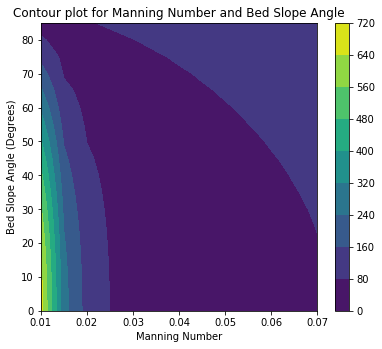

In [23]:
mann3_ls = np.arange(0.01, 0.075, 0.005)
a3_ls = range(0, 90, 5)
rms3_ls = np.zeros((len(a3_ls), len(mann3_ls)))

i=0
for mann3 in mann3_ls:
    j = 0
    for a3 in a3_ls:
        manning = mann3
        alpha = (a3/360)*(2*np.pi)
        results = runmodels() #emls_htdislodge, emls_hsdislodge, emls_hsdeposit, emls_htdeposit, gls, nls, pls_ht, pls_d, lt_actual)
        rms_value = rms(results[8], results[9])
        rms3_ls[j][i] = rms_value
        j = j + 1
    i = i + 1

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

X, Y = np.meshgrid(mann3_ls, a3_ls)
Z = rms3_ls
cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour plot for Manning Number and Bed Slope Angle') 
ax.set_ylabel('Bed Slope Angle (Degrees)')
ax.set_xlabel('Manning Number')
plt.savefig('contourmanningalpha.eps')
plt.show()

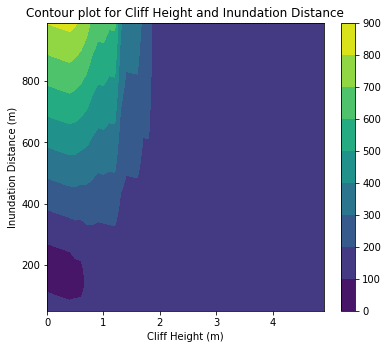

In [25]:
hc4_ls = np.arange(0, 5, 0.1)
xmax4_ls = np.arange(50, 1000, 10)
rms4_ls = np.zeros((len(xmax4_ls), len(hc4_ls))) # inner outer

i=0
for h4 in hc4_ls:
    j = 0
    for xmax4 in xmax4_ls:
        h_c = h4
        X_max = xmax4
        results = runmodels() #emls_htdislodge, emls_hsdislodge, emls_hsdeposit, emls_htdeposit, gls, nls, pls_ht, pls_d, lt_actual)
        rms_value = rms(results[8], results[9])
        rms4_ls[j][i] = rms_value
        j = j + 1
    i = i + 1

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

X, Y = np.meshgrid(hc4_ls, xmax4_ls) #outer inner
Z = rms4_ls
cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour plot for Cliff Height and Inundation Distance') 
ax.set_ylabel('Inundation Distance (m)')
ax.set_xlabel('Cliff Height (m)')
plt.savefig('contourhcxmax.eps')
plt.show()

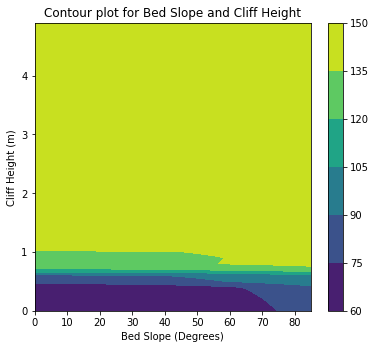

In [27]:
a5_ls = range(0, 90, 5)
hc5_ls = np.arange(0, 5, 0.1)
rms5_ls = np.zeros((len(hc5_ls), len(a5_ls))) # inner outer

i=0
for a5 in a5_ls:
    j = 0
    for h5 in hc5_ls:
        h_c = h5
        alpha = (a5/360)*(2*np.pi)
        results = runmodels() #emls_htdislodge, emls_hsdislodge, emls_hsdeposit, emls_htdeposit, gls, nls, pls_ht, pls_d, lt_actual)
        rms_value = rms(results[8], results[9])
        rms5_ls[j][i] = rms_value
        j = j + 1
    i = i + 1

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

X, Y = np.meshgrid(a5_ls, hc5_ls) #outer inner
Z = rms5_ls
cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour plot for Bed Slope and Cliff Height') 
ax.set_ylabel('Cliff Height (m)')
ax.set_xlabel('Bed Slope (Degrees)')
plt.savefig('contouralphahc.eps')
plt.show()

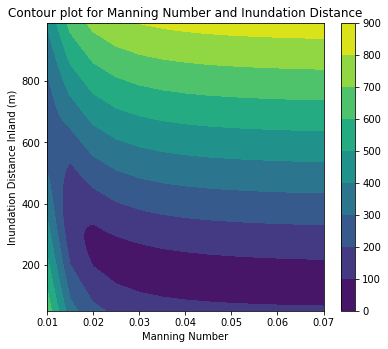

In [29]:
mann6_ls = np.arange(0.01, 0.075, 0.005)
xmax6_ls = np.arange(50, 1000, 10)
rms6_ls = np.zeros((len(xmax6_ls), len(mann6_ls))) # inner outer

i=0
for mann6 in mann6_ls:
    j = 0
    for x6 in xmax6_ls:
        manning = mann6
        X_max = x6
        results = runmodels() #emls_htdislodge, emls_hsdislodge, emls_hsdeposit, emls_htdeposit, gls, nls, pls_ht, pls_d, lt_actual)
        rms_value = rms(results[8], results[9])
        rms6_ls[j][i] = rms_value
        j = j + 1
    i = i + 1

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

X, Y = np.meshgrid(mann6_ls, xmax6_ls) #outer inner
Z = rms6_ls
cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour plot for Manning Number and Inundation Distance') 
ax.set_ylabel('Inundation Distance Inland (m)')
ax.set_xlabel('Manning Number')
plt.savefig('contourmanningxmax.eps')
plt.show()

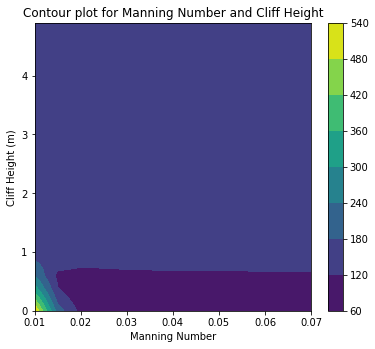

In [31]:
mann7_ls = np.arange(0.01, 0.075, 0.005)
hc7_ls = np.arange(0, 5, 0.1)
rms7_ls = np.zeros((len(hc7_ls), len(mann7_ls))) # inner outer

i=0
for mann7 in mann7_ls:
    j = 0
    for hc7 in hc7_ls:
        manning = mann7
        h_c = hc7
        results = runmodels() #emls_htdislodge, emls_hsdislodge, emls_hsdeposit, emls_htdeposit, gls, nls, pls_ht, pls_d, lt_actual)
        rms_value = rms(results[8], results[9])
        rms7_ls[j][i] = rms_value
        j = j + 1
    i = i + 1

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

X, Y = np.meshgrid(mann7_ls, hc7_ls) #outer inner
Z = rms7_ls
cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour plot for Manning Number and Cliff Height') 
ax.set_ylabel('Cliff Height (m)')
ax.set_xlabel('Manning Number')
plt.savefig('contourmanninghc.eps')
plt.show()

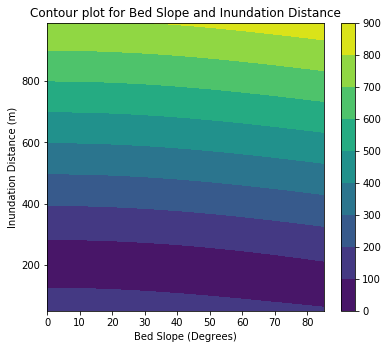

In [7]:
a8_ls = range(0, 90, 5)
xmax8_ls = np.arange(50, 1000, 10)
rms8_ls = np.zeros((len(xmax8_ls), len(a8_ls))) # inner outer

i=0
for a8 in a8_ls:
    j = 0
    for xmax8 in xmax8_ls:
        alpha = (a8/360)*(2*np.pi)
        X_max = xmax8
        results = runmodels() #emls_htdislodge, emls_hsdislodge, emls_hsdeposit, emls_htdeposit, gls, nls, pls_ht, pls_d, lt_actual)
        rms_value = rms(results[8], results[9])
        rms8_ls[j][i] = rms_value
        j = j + 1
    i = i + 1

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

X, Y = np.meshgrid(a8_ls, xmax8_ls) #outer inner
Z = rms8_ls
cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour plot for Bed Slope and Inundation Distance') 
ax.set_ylabel('Inundation Distance (m)')
ax.set_xlabel('Bed Slope (Degrees)')
plt.savefig('contouralphaxmax.eps')
plt.show()